In [1]:
import pandas as pd
import time
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import ydata_profiling as df_report

from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
import seaborn as sns
import plotly.express as px
import matplotlib as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from datetime import datetime
import sweetviz as sv
from sklearn.metrics import auc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import kds
from pytz import timezone
from tzfpy import get_tz, get_tzs

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


### Load data from private dataset and public dataset

In [2]:
df_usage = pd.read_csv('data/usage_data_per_tail.csv')
display(df_usage.head(2))
df_airtraffic_trends = pd.read_csv('data/Airline_Transportation_Data.csv')
display(df_airtraffic_trends.head(2))

,AIRLINE,TAIL_ID,USAGE_TSTAMP,PREMIUM_PRODUCT,ESI_PRODUCT,TMO_PRODUCT,BASIC_PRODUCT,OTHER_PRODUCT,DOOR_CLOSE_TSTAMP,DOOR_OPEN_PLUS15_TSTAMP,TIME_INTO_FLIGHT,FLIGHT_PHASE,LATITUDE,LONGITUDE,ALTITUDE,TOTAL_FL_MBPS,TOTAL_RL_MBPS
0,DAL,N6701,2023-05-15T19:25:00Z,1,0,0,0,1,2023-05-15T18:59:13.249Z,2023-05-15T20:39:18.333Z,26.0,10k,31.40,-82.17,26086.13,0.10,0.06
1,JBU-R,N565JB,2023-05-15T19:25:00Z,0,1,0,0,1,2023-05-15T16:11:14.392Z,2023-05-15T21:24:31.873Z,194.0,10k,29.22,-93.85,38977.25,0.15,0.02


,ID,OBS_DATE,ASM_US_D_I,ASM_D,ASM_I,LOAD_FACTOR_D_PCT_US,LOAD_FACTOR_I_PCT_US
0,SATD200001,1/1/00,76146639.0,56288872.0,19857767.0,62.0,67.2
1,SATD200002,2/1/00,73011377.0,54329819.0,18681558.0,66.3,67.3


### Performing column re-names, EDA,Data Cleaning, Feature Engineering and Feature Selection 

In [3]:

df_airtraffic_trends.rename(columns={'OBS_DATE': 'Month','ASM_US_D_I':'Aggr_seat_miles_domestic_and_international','LOAD_FACTOR_D_PCT_US':'Load_factor_domestic_pct_us'}, inplace=True)
df_airtraffic_trends.drop(['ID','ASM_D','ASM_I','LOAD_FACTOR_I_PCT_US'], axis=1, inplace=True)
df_airtraffic_trends['Month'] = pd.to_datetime(df_airtraffic_trends['Month'])
df_usage.columns = df_usage.columns.str.lower()
df_airtraffic_trends.columns = df_airtraffic_trends.columns.str.lower()
df_usage['usage_tstamp'] = pd.to_datetime(df_usage['usage_tstamp'])
df_usage['door_close_tstamp'] = pd.to_datetime(df_usage['door_close_tstamp'])
df_usage['door_open_plus15_tstamp'] = pd.to_datetime(df_usage['door_open_plus15_tstamp'])

# Based on several iterations of the EDA, it felt like I need to come up with a new feature which is percentage of flight completed 
# and need to find all time related variables in local time than in utc. Used lat,lon to convert time to local timezone.
# Dropped all rows with null vallues for lat,long

df_usage['pct_flight_completed'] = df_usage['time_into_flight']/((df_usage['door_open_plus15_tstamp'] - df_usage['door_close_tstamp']).dt.total_seconds() / 60)
df_usage.drop(['tail_id','door_close_tstamp','door_open_plus15_tstamp'], axis=1, inplace=True)
df_usage.dropna(subset=['latitude','longitude'],inplace=True)

# The initial data set had a lot of datapoints, so I sampled 1% of the data to do the EDA and build the model
df_usage_sampled = df_usage.sample(frac=0.02, random_state=42,replace=False)

display(df_airtraffic_trends.head(2))
display(df_usage_sampled.head(2))

,month,aggr_seat_miles_domestic_and_international,load_factor_domestic_pct_us
0,2000-01-01,76146639.0,62.0
1,2000-02-01,73011377.0,66.3


,airline,usage_tstamp,premium_product,esi_product,tmo_product,basic_product,other_product,time_into_flight,flight_phase,latitude,longitude,altitude,total_fl_mbps,total_rl_mbps,pct_flight_completed
599069,UAL-R,2023-05-13 17:55:00+00:00,1,0,1,1,1,28.0,10k,39.79,-105.42,17030.13,3.78,0.34,0.218557
1771873,UAL-R,2023-05-11 17:00:00+00:00,0,0,0,0,1,6.0,g2g,33.94,-118.40,17.00,0.09,0.08,0.020319


In [4]:
# Performing timezone trasnlations to get local time as well as hour of day and day of week

df_usage_sampled['usage_utc_hour'] = df_usage_sampled['usage_tstamp'].dt.hour
df_usage_sampled['usage_month']=df_usage_sampled['usage_tstamp'].dt.month_name()
df_usage_sampled['usage_utc_day']=df_usage_sampled['usage_tstamp'].dt.day_name()

def local_time_mapper(x):
    return get_tz(lat=x['latitude'], lng=x['longitude'])


df_usage_sampled['usage_tz'] = df_usage_sampled.apply(lambda x: local_time_mapper(x), axis=1)

# Throwing away few rows which had no timezone look up, very small numebr of rows
df_usage_sampled = df_usage_sampled[df_usage_sampled['usage_tz']!='']

# Converting utc time to local time based on the timezone and then getting the local hour of the day and day of the week

df_usage_sampled['usage_local_hour'] = df_usage_sampled.apply(lambda row: row['usage_tstamp'].tz_convert(timezone(row['usage_tz'])).hour, axis=1)
df_usage_sampled['usage_local_hour_shifted'] = df_usage_sampled['usage_local_hour'].apply(lambda x: (pd.Timedelta(hours=x) + pd.Timedelta(hours=-3)).components.hours)
df_usage_sampled['usage_local_day'] = df_usage_sampled.apply(lambda row: row['usage_tstamp'].tz_convert(timezone(row['usage_tz'])).strftime("%A"), axis=1)

display(df_usage_sampled.head(2))

,airline,usage_tstamp,premium_product,esi_product,tmo_product,basic_product,other_product,time_into_flight,flight_phase,latitude,...,total_fl_mbps,total_rl_mbps,pct_flight_completed,usage_utc_hour,usage_month,usage_utc_day,usage_tz,usage_local_hour,usage_local_hour_shifted,usage_local_day
599069,UAL-R,2023-05-13 17:55:00+00:00,1,0,1,1,1,28.0,10k,39.79,...,3.78,0.34,0.218557,17,May,Saturday,America/Denver,11,8,Saturday
1771873,UAL-R,2023-05-11 17:00:00+00:00,0,0,0,0,1,6.0,g2g,33.94,...,0.09,0.08,0.020319,17,May,Thursday,America/Los_Angeles,10,7,Thursday


In [5]:
# Dropping un-wanted rows before doing one more final round of eda through sweetviz

df_usage_sampled.drop(['usage_tstamp','usage_tz'], axis=1, inplace=True)

df_usage_eda_report = sv.analyze(df_usage_sampled, target_feat='total_fl_mbps')
df_usage_eda_report.show_html('eda-viz/df_usage_per_tail_eda_report.html')


                                             |          | [  0%]   00:00 -> (? left)

Report eda-viz/df_usage_per_tail_eda_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [6]:
# Based on the output of the FInal run of eda, dropping unwanted columns as well as columns which are not available at the time of prediction ('total_rl_mbps')
df_usage_sampled.drop(columns=['usage_utc_day','usage_utc_hour','usage_local_hour','usage_month','latitude','longitude','time_into_flight','total_rl_mbps'],inplace=True)
df_usage_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54179 entries, 599069 to 1815541
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   airline                   54179 non-null  object 
 1   premium_product           54179 non-null  int64  
 2   esi_product               54179 non-null  int64  
 3   tmo_product               54179 non-null  int64  
 4   basic_product             54179 non-null  int64  
 5   other_product             54179 non-null  int64  
 6   flight_phase              54179 non-null  object 
 7   altitude                  54179 non-null  float64
 8   total_fl_mbps             54179 non-null  float64
 9   pct_flight_completed      54179 non-null  float64
 10  usage_local_hour_shifted  54179 non-null  int64  
 11  usage_local_day           54179 non-null  object 
dtypes: float64(3), int64(6), object(3)
memory usage: 5.4+ MB


In [7]:
# Converting local_hour and pct flight completed to categorical variables based on the output of final eda run
df_usage_sampled['usage_local_hour_shifted'] = df_usage_sampled['usage_local_hour_shifted'].astype('str')
df_usage_sampled['pct_flight_completed'] = round((100*df_usage_sampled['pct_flight_completed']/10),0).astype('str')

In [8]:
#throwing outliers in total_fl_mbps which are between 0.1 and  99.5th percentile
df_usage_sampled = df_usage_sampled[ ( df_usage_sampled['total_fl_mbps']<df_usage_sampled['total_fl_mbps'].quantile(0.995)) & (df_usage_sampled['total_fl_mbps']>df_usage_sampled['total_fl_mbps'].quantile(0.001)) ]

In [9]:
# Applying column transformer to encode categorical variables and scale numeric variables

# Get columns of integer or float type
numeric_cols = df_usage_sampled.select_dtypes(include=['int64', 'float64']).columns
print(numeric_cols)
# Get columns of object type
object_cols = df_usage_sampled.select_dtypes(include=['object']).columns
print(object_cols)

# Categorical feature columns to one-hot encode
categorical_cols = ['airline','flight_phase','usage_local_day','pct_flight_completed','usage_local_hour_shifted','pct_flight_completed']
# Numerical feature columns to standard scale
numerical_cols = ['altitude']

# Create transformers for one-hot encoding and standard scaling
column_trans = ColumnTransformer(
    transformers=[
        ('ohe',OneHotEncoder(sparse=False), categorical_cols),
        ('std_scaled',StandardScaler(), numerical_cols),
    ],
    remainder='passthrough',
    )
column_trans.set_output(transform='pandas')
transformed_data = column_trans.fit_transform(df_usage_sampled)
df_usage_column_transformed = pd.DataFrame(transformed_data)

df_usage_column_transformed.rename(columns={'remainder__total_fl_mbps':'total_fl_mbps'}, inplace=True)
display(df_usage_column_transformed.head(2))

Index(['premium_product', 'esi_product', 'tmo_product', 'basic_product',
       'other_product', 'altitude', 'total_fl_mbps'],
      dtype='object')
Index(['airline', 'flight_phase', 'pct_flight_completed',
       'usage_local_hour_shifted', 'usage_local_day'],
      dtype='object')


,ohe__airline_AAL,ohe__airline_AMX,ohe__airline_AZU,ohe__airline_DAL,ohe__airline_DJT,ohe__airline_ELY,ohe__airline_FIN,ohe__airline_ICE,ohe__airline_JBU,ohe__airline_JBU-R,...,ohe__pct_flight_completed_7.0,ohe__pct_flight_completed_8.0,ohe__pct_flight_completed_9.0,std_scaled__altitude,remainder__premium_product,remainder__esi_product,remainder__tmo_product,remainder__basic_product,remainder__other_product,total_fl_mbps
599069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.422102,1,0,1,1,1,3.78
1771873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.573586,0,0,0,0,1,0.09


In [10]:
# X_before_poly = df_usage_column_transformed.drop('total_fl_mbps', axis=1) 
# display(X_before_poly.shape)
# display(X_before_poly.head())
# poly_features = PolynomialFeatures(degree=2)
# X_poly = poly_features.fit_transform(X_before_poly)
# X = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X_before_poly.columns))

# display(X.shape)
# display(X.head())
display(df_usage_column_transformed.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 52184 entries, 599069 to 1815541
Data columns (total 84 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   ohe__airline_AAL                  52184 non-null  float64
 1   ohe__airline_AMX                  52184 non-null  float64
 2   ohe__airline_AZU                  52184 non-null  float64
 3   ohe__airline_DAL                  52184 non-null  float64
 4   ohe__airline_DJT                  52184 non-null  float64
 5   ohe__airline_ELY                  52184 non-null  float64
 6   ohe__airline_FIN                  52184 non-null  float64
 7   ohe__airline_ICE                  52184 non-null  float64
 8   ohe__airline_JBU                  52184 non-null  float64
 9   ohe__airline_JBU-R                52184 non-null  float64
 10  ohe__airline_KLM                  52184 non-null  float64
 11  ohe__airline_MXY                  52184 non-null  float64
 1

None

In [13]:
# Split the df into train test split with 80:20 ratio 

X = df_usage_column_transformed.loc[:, df_usage_column_transformed.columns != 'total_fl_mbps']
y = df_usage_column_transformed['total_fl_mbps']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining a set of regression models to be used for hyper parameter tuning

regressors = {
    'Linear Regression': (LinearRegression(), {}),
    'Ridge Regression': (Ridge(fit_intercept=False), {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}),
    'Lasso Regression': (Lasso(), {'alpha': [0.00001,0.0001,0.001,0.01, 0.1, 1.0, 10.0, 100.0]}),
    'Random Forest Regressor': (RandomForestRegressor(n_jobs=-1), {'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [5, 7, 10, 15, 20, 40]}),
    #'Support Vector Regressor': (SVR(), {'C': [1, 10], 'kernel': ['linear', 'rbf']})
}

best_models = []
# Perform grid search for each regressor
for regressor_name, (regressor, param_grid) in regressors.items():
    grid_search = GridSearchCV(regressor, param_grid, scoring='r2', cv=5, verbose=2)
    grid_search.fit(X_train, y_train)

    # Get the best estimator and make predictions
    best_regressor = grid_search.best_estimator_
    y_pred = best_regressor.predict(X_test)

    # Calculate and print the R2 score

    r2 = r2_score(y_test, y_pred)
    print(f"{regressor_name}: Best Parameters: {grid_search.best_params_}, R2 Score: {r2}")
    best_models.append({'regressor':regressor_name,'model':best_regressor})


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
[CV] END .................................................... total time=   0.2s
Linear Regression: Best Parameters: {}, R2 Score: 0.38033706958570535
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ........................................alpha=0.001; total time=   0.1s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.324e+05, tolerance: 1.781e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   3.0s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e+05, tolerance: 1.771e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   3.1s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.321e+05, tolerance: 1.774e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   2.9s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e+05, tolerance: 1.789e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   3.1s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.321e+05, tolerance: 1.780e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=   3.5s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.099e+05, tolerance: 1.781e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   2.1s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.092e+05, tolerance: 1.771e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   2.2s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.096e+05, tolerance: 1.774e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   2.2s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.099e+05, tolerance: 1.789e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   2.4s


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+05, tolerance: 1.780e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time=   2.5s
[CV] END ........................................alpha=0.001; total time=   1.4s
[CV] END ........................................alpha=0.001; total time=   1.4s
[CV] END ........................................alpha=0.001; total time=   1.9s
[CV] END ........................................alpha=0.001; total time=   1.5s
[CV] END ........................................alpha=0.001; total time=   1.6s
[CV] END .........................................alpha=0.01; total time=   0.4s
[CV] END .........................................alpha=0.01; total time=   0.4s
[CV] END .........................................alpha=0.01; total time=   0.3s
[CV] END .........................................alpha=0.01; total time=   0.3s
[CV] END .........................................alpha=0.01; total time=   0.3s
[CV] END ..........................................alpha=0.1; total time=   0.1s
[CV] END ...................

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.245e+05, tolerance: 2.224e+02
  model = cd_fast.enet_coordinate_descent(


[CV] END .......................max_depth=5, n_estimators=10; total time=  10.7s
[CV] END .......................max_depth=5, n_estimators=10; total time=   1.3s
[CV] END .......................max_depth=5, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=10; total time=   0.3s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.5s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=20; total time=   0.4s
[CV] END .......................max_depth=5, n_estimators=30; total time=   0.5s
[CV] END .......................max_depth=5, n_estimators=30; total time=   0.5s
[CV] END ...................

In [17]:
display(best_models[3]['regressor'])
display(best_models[3]['model'].feature_importances_)
importances = best_models[3]['model'].feature_importances_

'Random Forest Regressor'

array([8.03822057e-03, 2.63497299e-03, 1.08043917e-04, 2.09377094e-01,
       3.08377210e-05, 7.41925222e-04, 0.00000000e+00, 5.63496097e-05,
       1.14102221e-02, 8.71654897e-02, 1.16337157e-05, 1.68573803e-03,
       2.17171553e-03, 5.44922435e-06, 9.83556444e-03, 5.62680331e-02,
       4.81857107e-05, 1.58141240e-04, 1.98469612e-04, 3.08226601e-05,
       2.84929516e-05, 7.55025276e-04, 2.32933981e-01, 5.85708943e-04,
       3.85580033e-03, 4.50264471e-03, 1.42969212e-02, 5.81197178e-03,
       3.79305529e-03, 4.06158921e-03, 4.87861269e-03, 7.07562204e-04,
       1.68904386e-03, 6.72012284e-03, 1.68560078e-03, 1.45832188e-03,
       1.13796474e-03, 1.15428185e-03, 8.89083032e-04, 1.64882575e-03,
       3.28427606e-03, 4.36619820e-03, 7.17910058e-03, 8.37023362e-03,
       3.75461806e-03, 2.85986950e-03, 1.96470334e-03, 3.07406004e-03,
       2.20058128e-03, 1.83963224e-03, 2.75164850e-03, 2.05101282e-03,
       2.44769755e-03, 2.06984122e-03, 9.70798153e-03, 3.01668585e-03,
      

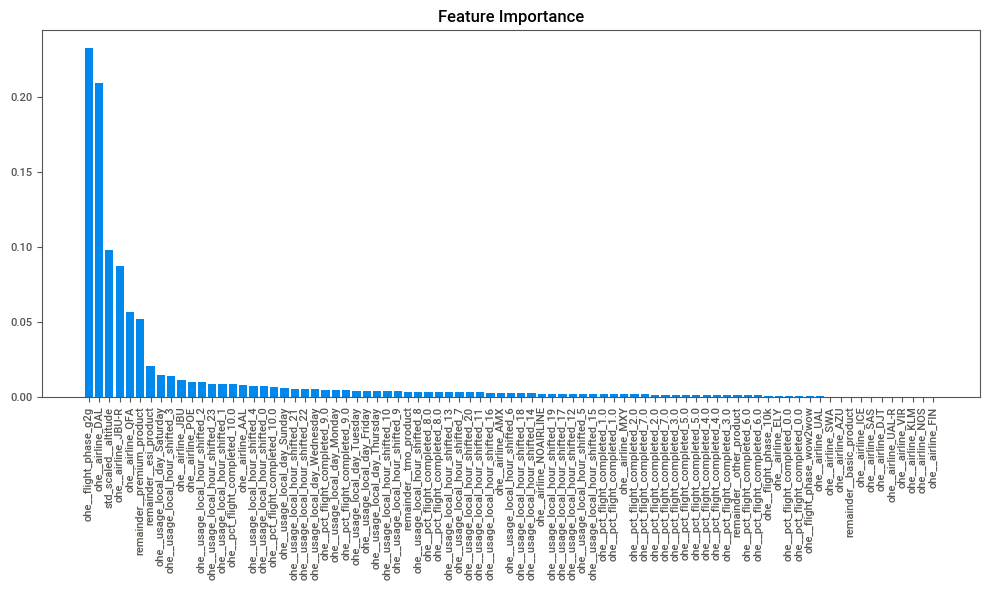

In [20]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = X_test.columns[indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_test.shape[1]), sorted_importances, align="center")
plt.xticks(range(X_test.shape[1]), sorted_features, rotation=90)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
# Print mean absolute percentage error (MAPE), R2 score, and mean absolute error (MAE)


best_regressor = best_models[3]['model']
y_pred = best_regressor.predict(X_test)

# Calculate and print the MAPE score
mape = round(mean_absolute_percentage_error(y_test, y_pred),2)
mae = round(mean_absolute_error(y_test, y_pred),2)
mse = round(mean_squared_error(y_test, y_pred),2)
r2 = r2_score(y_test, y_pred)
print("Best Regressor's Scores: MAPE : {mape}, MAE : {mae}, MSE : {mse}, R2 : {r2}".format(mape=mape,mse=mse,mae=mae,r2=r2))

Best Regressor's Scores: MAPE : 7.39, MAE : 3.99, MSE : 30.17, R2 : 0.4281369369119157


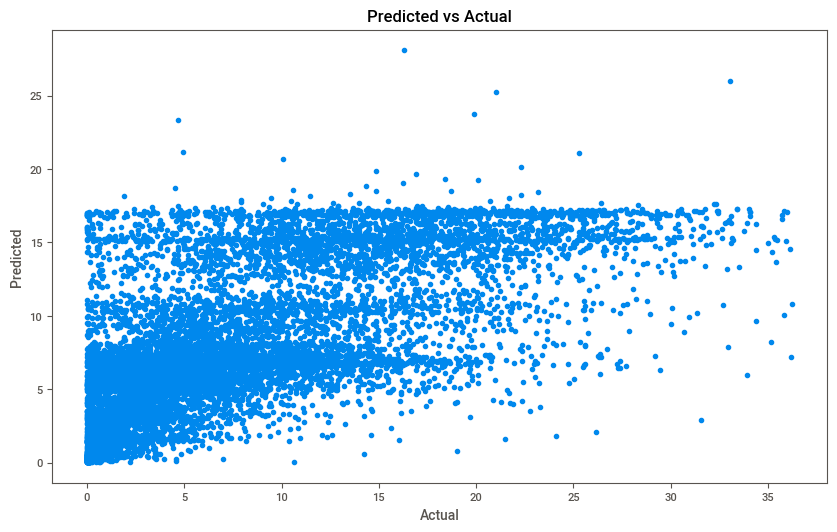

In [22]:
# Plot the predicted vs actual values
plt.figure(figsize=(10, 6))
plt.title("Predicted vs Actual")
plt.scatter(y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()